In [129]:
import os
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss

In [130]:
DATASET_NAME = "data.csv"
data = pd.read_csv(DATASET_NAME)

X_data = data['Title']
y_data = data['label(긍정1, 부정0)']

In [131]:
TEST_SIZE = 0.3 # Train: Test = 7 : 3 분리
RANDOM_STATE = 77
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = TEST_SIZE,
                                                    random_state = RANDOM_STATE,
                                                    stratify = y_data)

In [132]:
MODEL_NAME = "klue/bert-base"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
MAX_SEQ_LEN = 256

In [133]:
def convert_data(X_data, y_data):
    # BERT 입력으로 들어가는 token, mask, segment, target 저장용 리스트
    tokens, masks, segments, targets = [], [], [], []
    
    for X, y in tqdm(zip(X_data, y_data)):
        # token: 입력 문장 토큰화
        token = tokenizer.encode(X, truncation = True, padding = 'max_length', max_length = MAX_SEQ_LEN)
        
        # Mask: 토큰화한 문장 내 패딩이 아닌 경우 1, 패딩인 경우 0으로 초기화
        num_zeros = token.count(0)
        mask = [1] * (MAX_SEQ_LEN - num_zeros) + [0] * num_zeros
        
        # segment: 문장 전후관계 구분: 오직 한 문장이므로 모두 0으로 초기화
        segment = [0]*MAX_SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        targets.append(y)

    # numpy array로 저장
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

In [134]:
def convert_data_x(X_data):
    # BERT 입력으로 들어가는 token, mask, segment, target 저장용 리스트
    tokens, masks, segments = [], [], []
    
    for X in tqdm(X_data):
        # token: 입력 문장 토큰화
        token = tokenizer.encode(X, truncation = True, padding = 'max_length', max_length = MAX_SEQ_LEN)
        
        # Mask: 토큰화한 문장 내 패딩이 아닌 경우 1, 패딩인 경우 0으로 초기화
        num_zeros = token.count(0)
        mask = [1] * (MAX_SEQ_LEN - num_zeros) + [0] * num_zeros
        
        # segment: 문장 전후관계 구분: 오직 한 문장이므로 모두 0으로 초기화
        segment = [0]*MAX_SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)

    # numpy array로 저장
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)

    return [tokens, masks, segments]

In [135]:
def convert_data_one_x(X_data):
    # BERT 입력으로 들어가는 token, mask, segment, target 저장용 리스트
    tokens, masks, segments = [], [], []
    
    # token: 입력 문장 토큰화
    token = tokenizer.encode(X_data, truncation = True, padding = 'max_length', max_length = MAX_SEQ_LEN)
    
    # Mask: 토큰화한 문장 내 패딩이 아닌 경우 1, 패딩인 경우 0으로 초기화
    num_zeros = token.count(0)
    mask = [1] * (MAX_SEQ_LEN - num_zeros) + [0] * num_zeros
    
    # segment: 문장 전후관계 구분: 오직 한 문장이므로 모두 0으로 초기화
    segment = [0]*MAX_SEQ_LEN

    tokens.append(token)
    masks.append(mask)
    segments.append(segment)

    # numpy array로 저장
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)

    return [tokens, masks, segments]

In [136]:
# train 데이터를 Bert의 Input 타입에 맞게 변환
train_x, train_y = convert_data(X_train, y_train)
# test 데이터를 Bert의 Input 타입에 맞게 변환
test_x, test_y = convert_data(X_test, y_test)

445it [00:00, 3308.84it/s]
192it [00:00, 3840.37it/s]


In [137]:
BEST_MODEL_NAME = './model/best.h5'

In [138]:
# 최고 성능의 모델 불러오기
sentiment_model_best = tf.keras.models.load_model(BEST_MODEL_NAME,
                                                  custom_objects={'TFBertForSequenceClassification': TFBertForSequenceClassification})

In [139]:
x = convert_data_one_x("미국 연수(캘리포니아 얼바인 거주) 시절 부러웠던 것 중 하나가 중증 장애인에 대한 배려였다.")
pre = sentiment_model_best.predict(x)
label = np.argmax(pre, axis = 1)


1/1 [==============================] - 6s 6s/step


In [145]:
pre

array([[0.38992953, 0.6056563 ]], dtype=float32)

In [140]:
print(label)

[1]


In [141]:
predicted_value = sentiment_model_best.predict(test_x)
predicted_label = np.argmax(predicted_value, axis = 1)
len(predicted_label)

6/6 [==============================] - 43s 7s/step


192

In [142]:
len(test_y)

192

In [143]:
cl_report = classification_report(test_y, predicted_label, output_dict = True)
cl_report_df = pd.DataFrame(cl_report).transpose()
cl_report_df = cl_report_df.round(3)
print(cl_report_df)

              precision  recall  f1-score  support
0                 0.981   0.936     0.958  109.000
1                 0.920   0.976     0.947   83.000
accuracy          0.953   0.953     0.953    0.953
macro avg         0.951   0.956     0.953  192.000
weighted avg      0.955   0.953     0.953  192.000


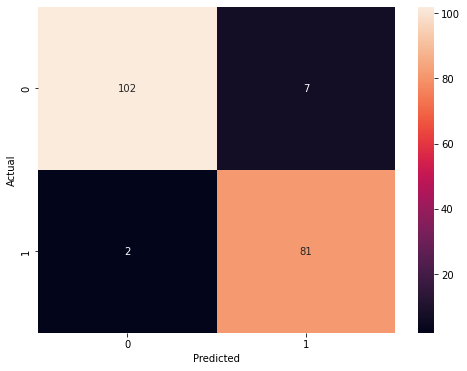

In [144]:
cf_matrix = confusion_matrix(test_y, predicted_label)
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(cf_matrix, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()